In [10]:
# Importando todas as ferramentas do nosso laboratório
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
import warnings

# Configurações para uma melhor visualização
warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid", palette="viridis")
plt.rcParams['figure.figsize'] = (15, 8)

print("Ambiente de análise e bibliotecas carregados com sucesso!")

Ambiente de análise e bibliotecas carregados com sucesso!


In [11]:
print("--- Passo 1: Carregando dados locais coletados pelo bot ---")

# O caminho aponta para o arquivo que nosso bot em Go está criando na pasta vizinha
file_path = '../sniper-bot/mainnet_data.jsonl'
df = pd.DataFrame()

try:
    # read_json com lines=True é perfeito para nosso arquivo .jsonl
    df = pd.read_json(file_path, lines=True)
    print(f"Sucesso! Carregamos {len(df)} transações diretamente do arquivo local.")
    display(df.head())
except Exception as e:
    print(f"--- ERRO ao carregar arquivo '{file_path}': {e} ---")
    print("Verifique se o bot coletor já salvou algum dado e se o caminho do arquivo está correto.")

--- Passo 1: Carregando dados locais coletados pelo bot ---
Sucesso! Carregamos 3270 transações diretamente do arquivo local.


,hash,to,from,nonce,gasPrice,gasLimit,value,timestamp,inputData,baseFeePerGas
0,0x1cd34a05a6a0d22e42de0df8684f0201002326ecde2d...,0x7a250d5630B4cF539739dF2C5dAcb4c659F2488D,0x0000000000000000000000000000000000000000,272,10012578380,325008,2.327900e+17,2025-07-11 17:29:23,0x7ff36ab5000000000000000000000000000000000000...,4286104235
1,0x58c21ca1ff6745018a392b9597e1be1ede39ecd07ebe...,0x7a250d5630B4cF539739dF2C5dAcb4c659F2488D,0x3C98602EE8C0A03b678673ec56594f90f865AaA8,29,5545133621,300000,0.000000e+00,2025-07-11 17:29:23,0x791ac947000000000000000000000000000000000000...,4286104235
2,0x991ae9a244b4f9d86f993fb9390c6c191cc02457ca66...,0x68b3465833fb72A70ecDF485E0e4C7bD8665Fc45,0x0000000000000000000000000000000000000000,184056,7140000000,130297,0.000000e+00,2025-07-11 17:29:35,0x04e45aaf0000000000000000000000008248270620aa...,4265713461
3,0xb47bfda1ca296bd6f45a8a174b56e7cd1079d81539ff...,0x7a250d5630B4cF539739dF2C5dAcb4c659F2488D,0x0000000000000000000000000000000000000000,105,10072208470,500000,0.000000e+00,2025-07-11 17:29:35,0x791ac947000000000000000000000000000000000000...,4265713461
4,0x4a819534d371a44066280c2ee45ecef92d8ff1aa91b0...,0x7a250d5630B4cF539739dF2C5dAcb4c659F2488D,0x0000000000000000000000000000000000000000,33344,15860339151,860989,5.000000e+16,2025-07-11 17:29:35,0xb6f9de95000000000000000000000000000000000000...,4265713461


--- Passo 2: Engenharia de Features e Análise Exploratória ---
Analisando 3270 transações válidas após limpeza.

Features criadas com sucesso!


,value,gasLimit,priority_fee,input_data_size
count,3.270000e+03,3.270000e+03,3.270000e+03,3270.000000
mean,1.616435e+17,3.854978e+05,5.673695e+09,512.623853
std,1.347848e+18,2.750632e+05,1.015746e+10,119.329666
min,0.000000e+00,1.000000e+05,0.000000e+00,10.000000
25%,0.000000e+00,2.480840e+05,3.885171e+08,458.000000
50%,0.000000e+00,3.176280e+05,2.582246e+09,522.000000
75%,1.041495e+17,5.000000e+05,4.945335e+09,522.000000
max,6.000000e+19,3.500000e+06,9.915902e+10,2634.000000


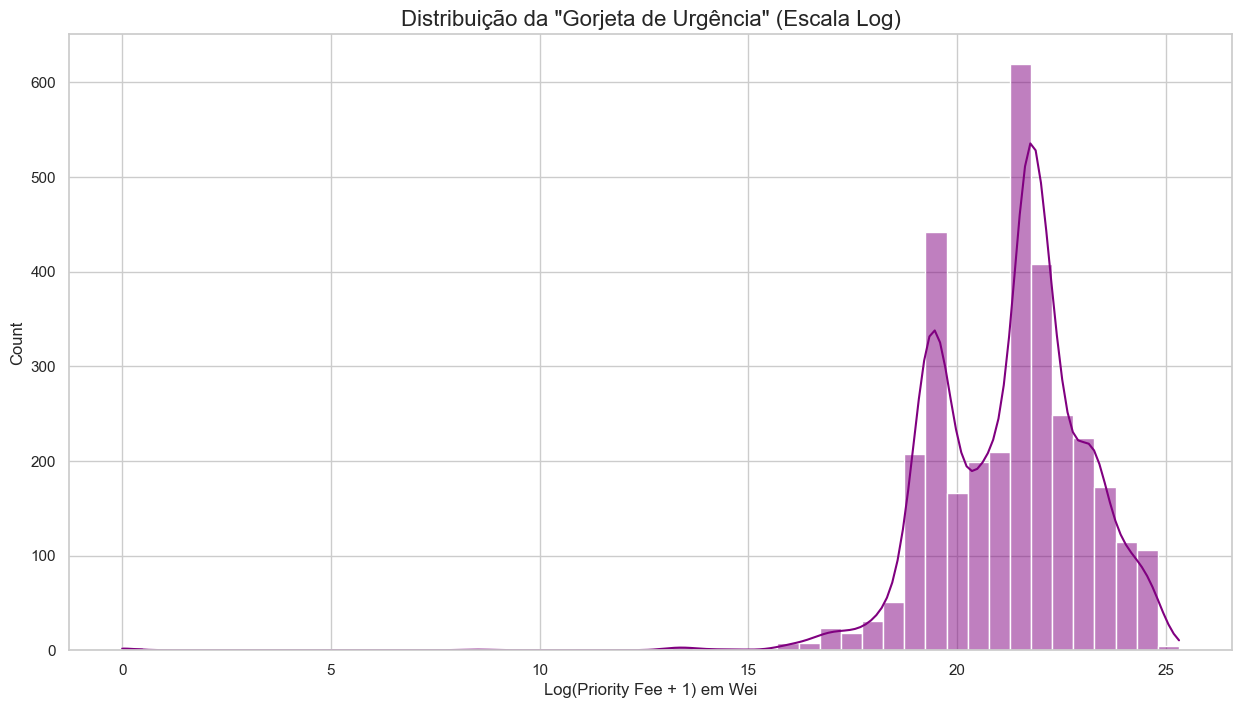

In [12]:
if not df.empty:
    print("--- Passo 2: Engenharia de Features e Análise Exploratória ---")
    
    # Limpeza e conversão de tipos de dados
    for col in ['gasPrice', 'baseFeePerGas', 'value', 'gasLimit', 'nonce']:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df.dropna(inplace=True)
    print(f"Analisando {len(df)} transações válidas após limpeza.")
    
    # Criando as features comportamentais
    df['priority_fee'] = df['gasPrice'] - df['baseFeePerGas']
    df['priority_fee'] = df['priority_fee'].apply(lambda x: max(x, 0))
    df['input_data_size'] = df['inputData'].apply(len)

    print("\nFeatures criadas com sucesso!")
    display(df[['value', 'gasLimit', 'priority_fee', 'input_data_size']].describe())

    # GRÁFICO 1: Para sua apresentação - Como as "gorjetas de urgência" se distribuem?
    plt.figure()
    sns.histplot(np.log1p(df['priority_fee']), kde=True, bins=50, color='purple')
    plt.title('Distribuição da "Gorjeta de Urgência" (Escala Log)', fontsize=16)
    plt.xlabel('Log(Priority Fee + 1) em Wei')
    plt.show()
else:
    print("DataFrame vazio. Verifique a Célula 1.")


--- Passo 3: Treinando o Modelo e Visualizando Anomalias ---
Modelo aprendendo o padrão de transações 'normais'...

Análise concluída!
O modelo identificou 327 transações como anomalias (potenciais alvos).


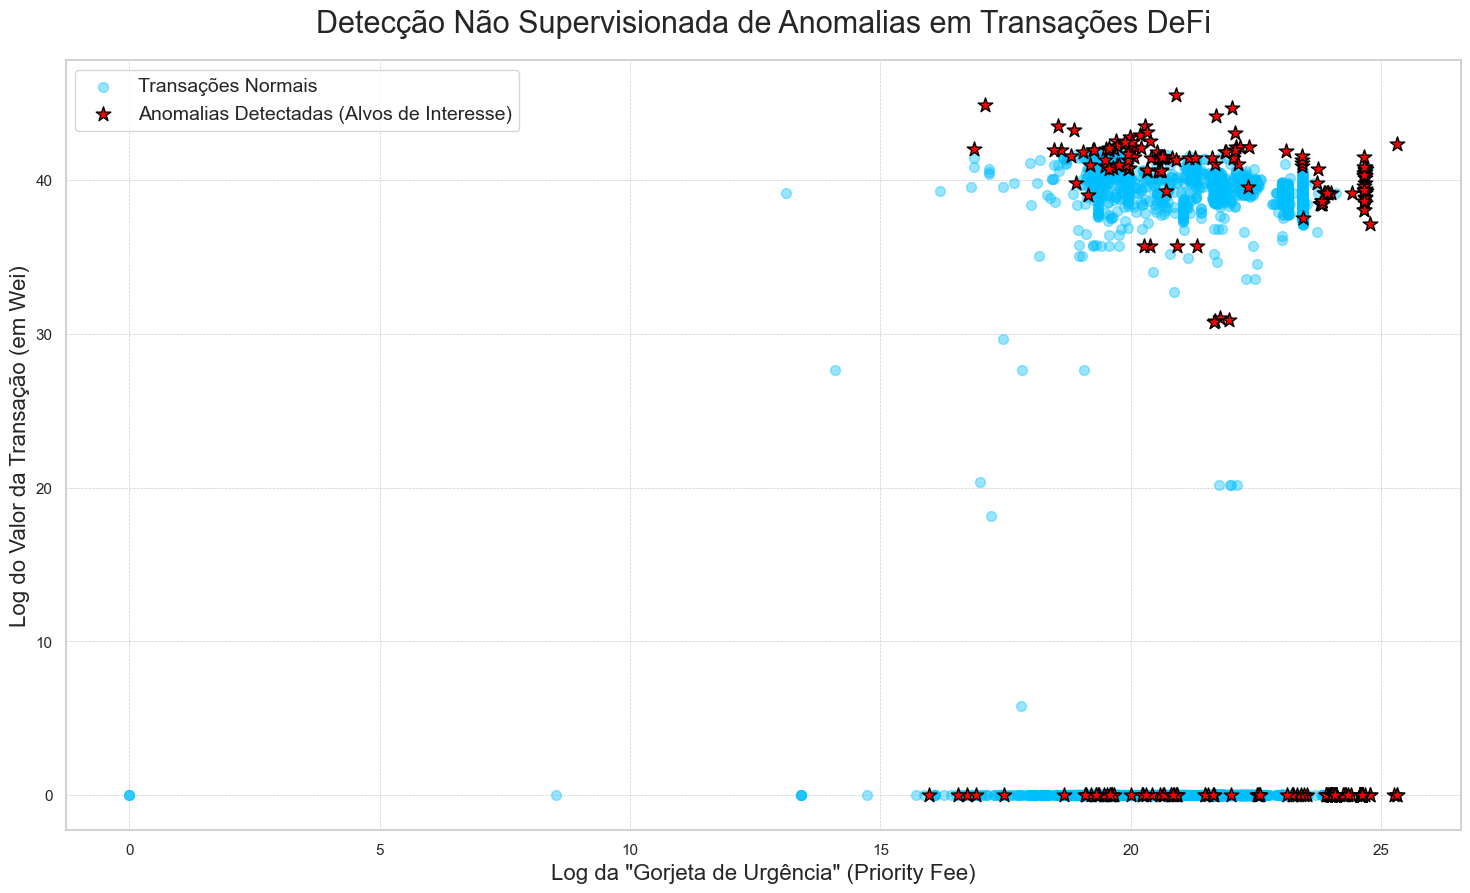

In [13]:
if 'df' in locals() and not df.empty:
    print("\n--- Passo 3: Treinando o Modelo e Visualizando Anomalias ---")
    
    # Selecionamos as features que o modelo usará
    features_df = df[['value', 'gasLimit', 'priority_fee', 'input_data_size']]
    
    # Treinamos o modelo para encontrar os 10% de transações mais anômalas
    model = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
    
    print("Modelo aprendendo o padrão de transações 'normais'...")
    df['anomaly'] = model.fit_predict(features_df)
    
    anomalies = df[df['anomaly'] == -1]
    normals = df[df['anomaly'] == 1]
    
    print("\nAnálise concluída!")
    print(f"O modelo identificou {len(anomalies)} transações como anomalias (potenciais alvos).")
    
    # O GRÁFICO FINAL
    plt.figure(figsize=(18, 10))
    plt.scatter(np.log1p(normals['priority_fee']), np.log1p(normals['value']), 
                c='deepskyblue', label='Transações Normais', alpha=0.4, s=50)
    plt.scatter(np.log1p(anomalies['priority_fee']), np.log1p(anomalies['value']), 
                c='red', label='Anomalias Detectadas (Alvos de Interesse)', s=120, edgecolor='black', marker='*')
    
    plt.title('Detecção Não Supervisionada de Anomalias em Transações DeFi', fontsize=22, pad=20)
    plt.xlabel('Log da "Gorjeta de Urgência" (Priority Fee)', fontsize=16)
    plt.ylabel('Log do Valor da Transação (em Wei)', fontsize=16)
    plt.legend(fontsize=14)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()
else:
    print("Nenhum dado para analisar.")

In [14]:
import joblib

# Só executa se o modelo foi treinado com sucesso
if 'model' in locals():
    # Define o nome do arquivo onde o modelo será salvo
    model_filename = 'anomaly_detection_model_v1.pkl'
    
    # Usa a biblioteca joblib para "congelar" nosso modelo treinado em um arquivo
    joblib.dump(model, model_filename)
    
    print(f"==================================================================")
    print(f"!!! SUCESSO TOTAL !!!")
    print(f"O seu modelo de IA treinado foi salvo com sucesso no arquivo:")
    print(f"'{model_filename}'")
    print(f"==================================================================")
else:
    print("A variável 'model' não foi encontrada. Execute a célula de treinamento primeiro.")

!!! SUCESSO TOTAL !!!
O seu modelo de IA treinado foi salvo com sucesso no arquivo:
'anomaly_detection_model_v1.pkl'
